# Environment Setup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json
import zipfile
import os

import random
import shutil
random.seed(123)

## PySpark

In [ ]:
spark_version = "3.0.0"
hadoop_version = "3.2"
package_name = "spark-" + spark_version + "-bin-hadoop" + hadoop_version + ".tgz"

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-$spark_version/$package_name
!echo $package_name
!tar xf $package_name

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-" + spark_version + "-bin-hadoop" + hadoop_version

!pip install -q findspark
!pip install pyspark==$spark_version

spark-3.0.0-bin-hadoop3.2.tgz
     |████████████████████████████████| 204.7 MB 20 kB/s 
     |████████████████████████████████| 198 kB 42.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=36d0afe87ec31483c87a3d3890696f161afd901725a4fa8cc4559c7bb6bdb95c
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

import pyspark.sql.functions as F

spark

## Dataset

While we have access to the consumption of several different countys, the amount of data is vast enough for us to for now only focus on one county due to computation limitations of our hardware. We have however written the code in such a way that its easy to just concatenate the csvs into one if one would like to utilise the full dataset. 

In [ ]:
# This utility code was written by Gustaf Halvardsson for another course
# IMPORTANT: Do not share the API-key in this notebook with anyone in any way

kaggle = {
    "username": "gustafhalvardsson",
    "api_key": "24da3141ae64a19be81567d78d94e86a",
    "on_kernel": False,
    "dataset": {
        "sample": "-",
        "full": "robikscube/hourly-energy-consumption"
        }
}

if kaggle["on_kernel"]:
  path_prefix = '/kaggle/working/'
else:
  path_prefix = '/content/'

# Download dataset
def download_dataset(which_dataset):
  data = {"username": kaggle["username"],"key": kaggle["api_key"]}
  with open('kaggle.json', 'w') as json_file:
      json.dump(data, json_file)

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  kaggle_dataset = kaggle["dataset"][which_dataset]
  !kaggle datasets download -d $kaggle_dataset
  
  # Paths neeeds to be changed manually because of different directory structures, check with !ls
  if not os.path.isdir('Data'):
    print("Unzipping... ")
    zip_ref = zipfile.ZipFile('hourly-energy-consumption.zip', 'r')
    zip_ref.extractall('Data')
    zip_ref.close()
  

  #!ls Data

download_dataset("full")

data_files = os.listdir("Data")
print(data_files)

 44% 5.00M/11.4M [00:00<00:01, 6.57MB/s]
100% 11.4M/11.4M [00:00<00:00, 13.8MB/s]
Unzipping... 
['FE_hourly.csv', 'PJME_hourly.csv', 'pjm_hourly_est.csv', 'DOM_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'PJM_Load_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'DEOK_hourly.csv', 'PJMW_hourly.csv', 'NI_hourly.csv']


# Data Exploration

In [ ]:
#df = spark.read.csv("Data/"+ data_files[0], header='true')
df = spark.read.csv("Data/"+ "AEP_hourly.csv", header='true')

df = df.withColumnRenamed(df.columns[1],"MW")
df = df.withColumn("MW",df.MW.cast('double'))

# Pandas 
pandas_df = df.toPandas()
print(pandas_df.shape)


pandas_df.head(3)

# Shorten dataset using pandas

short_dataset = False

if short_dataset:
  split_with = '2017-07-01 01:00:00'
  pandas_df = pandas_df.loc[pandas_df.index >= split_with].copy()
  #pandas_df['Datetime'] = pandas_df.index



# Recreate Spark Dataframe from filtered Pandas Dataframe
df = spark.createDataFrame(pandas_df[['Datetime', 'MW']]) 
pandas_df['Datetime'] = pd.to_datetime(pandas_df['Datetime'])
pandas_df = pandas_df.set_index('Datetime')

# Full dataset is Data from 2004-10-01 01:00:00 to 2018-08-03 00:00:00
print("Data from", pandas_df.index.min(), "to", pandas_df.index.max())
print("Number of samples:", pandas_df.shape[0])
df.show(3)
pandas_df.head(3)

(121273, 2)
Data from 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Number of samples: 121273
+-------------------+-------+
|           Datetime|     MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
+-------------------+-------+
only showing top 3 rows



,MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0


In [ ]:
# Find if there is any Null or Empty values
print("Number of Null values: ", df.where(F.col('MW').isNull()).count())
print("Number of Empty values: ", df.where(F.col('MW') == "").count())

Number of Null values:  0
Number of Empty values:  0


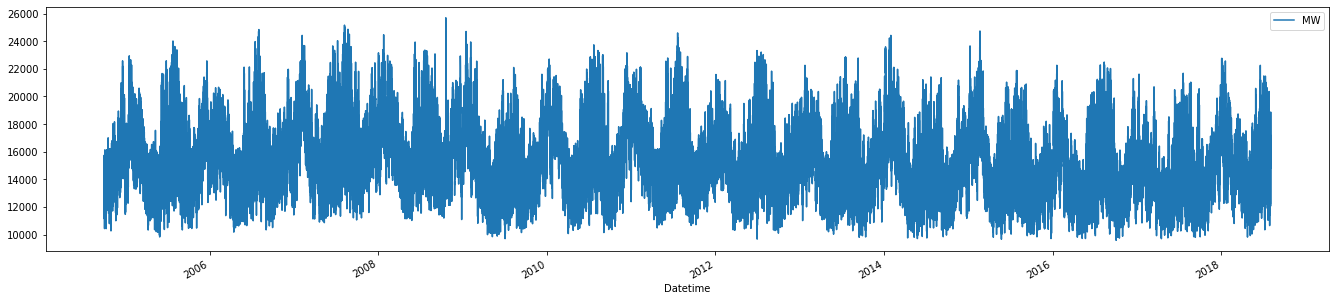

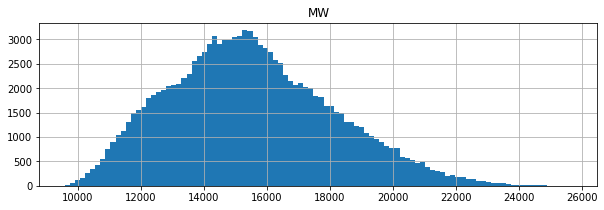

In [ ]:
# Plot data 
pandas_df.plot(y='MW', figsize=(23,5))

# Find out data distribution
hist = df.toPandas().hist(bins=100, figsize=(10,3))

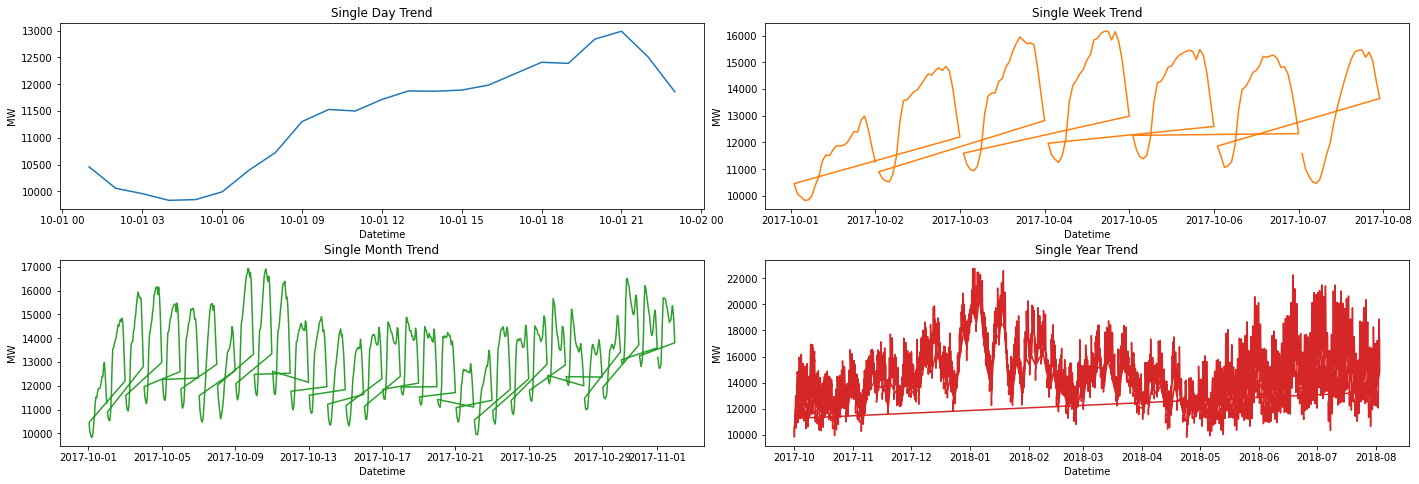

In [ ]:
# Horizontal lines seen in graph is due to the data not being enirely continuous  

fig, axs = plt.subplots(2, 2, figsize=(20,7))
fig.tight_layout(pad=3.0)
#Plot single day trend
axs[0, 0].plot(pandas_df['MW']['2017-10-01 01:00:00':'2017-10-01 23:00:00'] )
axs[0, 0].set_title('Single Day Trend')

#Plot single week trend
axs[0, 1].plot(pandas_df['MW']['2017-10-01 01:00:00':'2017-10-07 23:00:00'], 'tab:orange')
axs[0, 1].set_title('Single Week Trend')

#Plot single month trend
axs[1, 0].plot(pandas_df['MW']['2017-10-01 01:00:00':'2017-11-01 23:00:00'], 'tab:green')
axs[1, 0].set_title('Single Month Trend')

#Plot single year trend
axs[1, 1].plot(pandas_df['MW']['2017-10-01 01:00:00':'2018-10-01 23:00:00'], 'tab:red')
axs[1, 1].set_title('Single Year Trend')


for ax in axs.flat:
    ax.set(xlabel='Datetime', ylabel='MW')

## Train/Test Split

In [ ]:
# Split data into train and test

split_with = '2016-05-01 01:00:00'

train = pandas_df.loc[pandas_df.index < split_with].copy()
test = pandas_df.loc[pandas_df.index >= split_with].copy()

print(train.shape)
print(train.head(3))
print()
print(test.shape)
print(test.head(3))

n_train = float(train.shape[0])
n_test = float(test.shape[0])
n_total = float(pandas_df.shape[0])

print()
print("Train data:", round(100 * n_train / n_total, 2), "% of data")
print("Test data:", round(100 * n_test / n_total, 2), "% of data")

(101497, 1)
                          MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0

(19776, 1)
                          MW
Datetime                    
2016-12-31 01:00:00  14877.0
2016-12-31 02:00:00  14588.0
2016-12-31 03:00:00  14514.0

Train data: 83.69 % of data
Test data: 16.31 % of data


# Model

## Fit 

In [ ]:
from fbprophet import Prophet


# Adapt model, Prophet requires specific column names and not date as index
trainp = train.copy()
trainp['ds'] = trainp.index
trainp['y'] = trainp['MW']
trainp = trainp.reset_index()
trainp = trainp[['ds', 'y']]

model = Prophet(
    interval_width=0.80,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)


model.fit(trainp)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


## Build Predictor

We plot the predictions for all the test data we specified above.

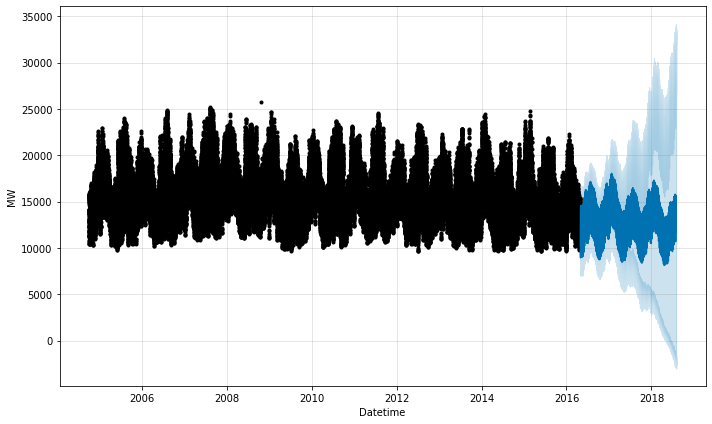

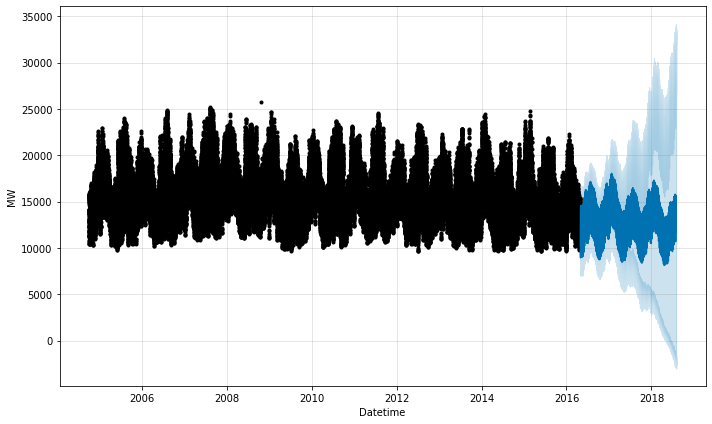

In [ ]:
# Adapt model, Prophet requires specific column names and not date as index
testp = test.copy()
testp['ds'] = testp.index
testp['y'] = testp['MW']
testp = testp.reset_index()
testp = testp[['ds', 'y']]

# Make predictions
predictions = model.predict(testp)
model.plot(predictions, xlabel='Datetime', ylabel='MW')

**Black dots** in the graph above represents the **actual values** from the training dataset, and the **dark blue** represents the **predicted values from our predictor**. We also plot a **confidence interval** as the **light blue**, which you can see becomes bigger and more uncertain the longer you try to predict into the future.

# Explore Predictions

## Trends & Seasonality

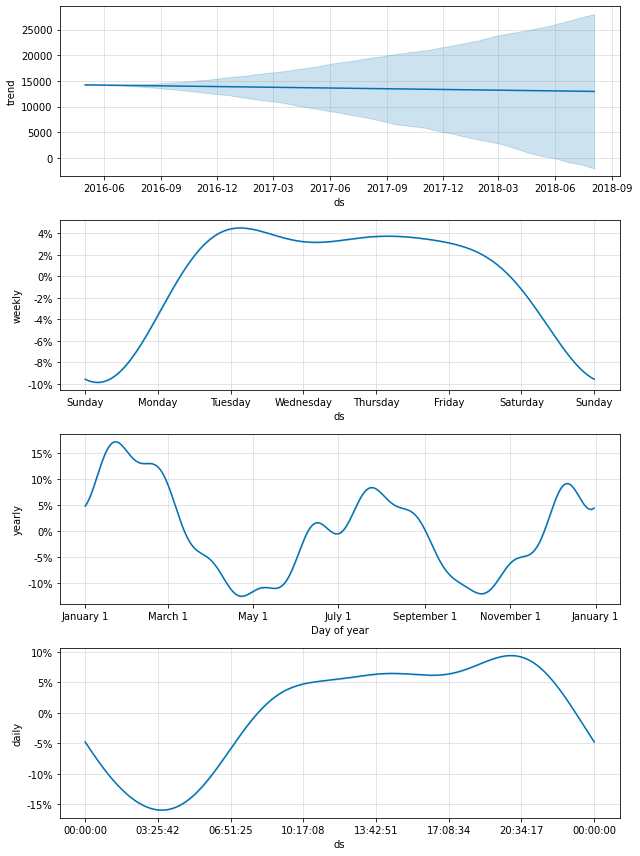

In [ ]:
# Show seasonality and trend in the data on a daily, weekly and yearly basis
model.plot_components(predictions);

## Evaluate Model

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-05-01 01:00:00,14239.827723,7729.194459,11744.419750,14239.827723,14239.827723,-0.097018,-0.097018,-0.097018,-0.309841,-0.309841,-0.309841,-0.096929,-0.096929,-0.096929,-0.115894,-0.115894,-0.115894,0.0,0.0,0.0,9827.746391
1,2016-05-01 02:00:00,14239.763282,7404.186729,11381.524026,14239.763282,14239.763282,-0.134375,-0.134375,-0.134375,-0.348063,-0.348063,-0.348063,-0.097860,-0.097860,-0.097860,-0.115828,-0.115828,-0.115828,0.0,0.0,0.0,9283.429148
2,2016-05-01 03:00:00,14239.698841,6969.773958,10941.465991,14239.698841,14239.698841,-0.155744,-0.155744,-0.155744,-0.369945,-0.369945,-0.369945,-0.098439,-0.098439,-0.098439,-0.115762,-0.115762,-0.115762,0.0,0.0,0.0,8971.797575


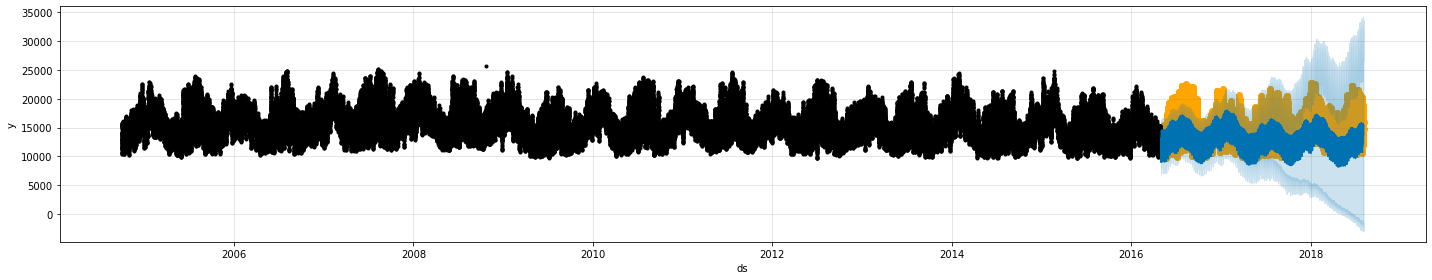

In [ ]:
# Compare our predictions with the actual values from the test dataset. 
fig, ax = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(20)

# Orange is the actual values in the graph
ax.scatter(test.index, test['MW'], color='orange')
figure = model.plot(predictions, ax=ax)

# Show structure of the prediction dataframe
predictions.head(3)

In [ ]:
# Evaluate using standardised metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true=test['MW'],
                   y_pred=predictions['yhat'])

mae = mean_absolute_error(y_true=test['MW'],
                   y_pred=predictions['yhat'])


# Code from sklearn beta
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) 
    return mape * 100


mape = mean_absolute_percentage_error(y_true=test['MW'],
                   y_pred=predictions['yhat'])
print("Mean Squared Error (MSE):", int(mse), "MW")
print("Mean Absolute Error (MAE):", int(mae), "MW")
print()
print("Mean Absolute Percentage Error (MAPE):", round(mape,2), "%")

Mean Squared Error (MSE): 7297738 MW
Mean Absolute Error (MAE): 2103 MW

Mean Absolute Percentage Error (MAPE): 13.61 %
